In [31]:
#Librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np   
import statsmodels.api as sm

# MMM Ratio(ventas/tráfico)


Dado que la empresa aplica una estrategia Click & Collect, donde las compras se realizan online pero se **recogen físicamente en tienda**, y no se contemplan ventas puramente online, optamos por estimar el siguiente ratio de conversión física:

$
Y_t = \frac{\text{Ventas}_t}{\text{Visitantes\_tienda}_t}
$

Este ratio representa la proporción de visitantes en tienda que efectivamente recogen una compra.

El modelo de regresión explica $ Y_t $ en función de:
- **Delay**: ratio $ Y_{t-1} $ del mes anterior.
- **% de presupuesto online y offline**.
- **Variables exógenas**, incluyendo el **tráfico web** $ \text{Unique\_visitors}_t $.

$
Y_t = \beta_0 + \beta_1 Y_{t-1} + \beta_2 \% \text{Online}_t + \beta_3 \% \text{Offline}_t + \beta_4 \text{Visitas\_Web}_t + \sum \beta_i X_{i,t} + \epsilon_t
$

## Carga datos y Tabla Final

In [32]:
df_web = pd.read_csv("../data/raw/web.csv", sep=",")
df_offline = pd.read_csv("../data/raw/offline.csv", sep=",")
df_time = pd.read_csv("../data/raw/time.csv", sep=",")
df_visit = pd.read_csv("../data/raw/visit.csv", sep=",")
df_inv = pd.read_csv("../data/raw/inv.csv", sep=",")

Tenemos que añadir los sufijos web y offline a las columans de estas tablas ya que sus nombre coinciden y posteriormente al hacer el merge necesitamos distinguirlas.

In [33]:
df_offline = df_offline.rename(columns={
    col: f"{col}_off" for col in df_offline.columns if col != "ID_Date"})


df_visit = df_visit.rename(columns={
    col: f"{col}_visit" for col in df_visit.columns if col != "ID_Date"})

### Tabla Inversión

Se han generado las siguientes métricas a partir de la tabla de inversión mensual(de cara a facilitar la evaluación del budget):

- `Pct_Online`: porcentaje de la inversión total del mes destinada a medios online.
- `Pct_Offline`: porcentaje de la inversión total del mes destinada a medios offline.
- `Pct_Otros`: porcentaje de la inversión total destinada a costes generales no atribuibles directamente a un canal.

In [34]:
# Online
inversion_online = df_inv['INTERNET'] + df_inv['PlataformasVideo']

# Offline
inversion_offline = (
    df_inv['CINE'] + df_inv['EXTERIOR'] + df_inv['PRENSA'] +
    df_inv['RADIO'] + df_inv['REVISTAS']
)

# Otros (costes generales de producción y varios)
otros = df_inv['PRODUCCION'] + df_inv['VARIOS']

# Asignar las sumas de las inversiones en valor absoluto
df_inv['Inversion_Online'] = inversion_online
df_inv['Inversion_Offline'] = inversion_offline
df_inv['Inversion_Otros'] = otros

In [35]:
df_inv.head()

,ID_Date,CINE,EXTERIOR,INTERNET,PRENSA,PRODUCCION,RADIO,REVISTAS,PlataformasVideo,VARIOS,INV_Total,Inversion_Online,Inversion_Offline,Inversion_Otros
0,202201,59887.84,8200.00,133666.43,0.0,6050.0,2426.40,18013.50,338824.94,7531.03,574600.14,472491.37,88527.74,13581.03
1,202202,72291.56,94627.51,189275.94,10000.0,6700.0,0.00,49110.91,487537.14,6972.02,916515.08,676813.08,226029.98,13672.02
2,202203,55000.00,0.00,214037.62,4500.0,3700.0,0.00,0.00,75000.00,15284.85,367522.47,289037.62,59500.00,18984.85
3,202204,10883.30,0.00,194816.97,48800.0,21550.0,1140.00,40876.00,610865.89,12255.75,941187.91,805682.86,101699.30,33805.75
4,202205,74333.20,0.00,130795.16,11000.0,4900.0,102851.86,20775.75,393807.74,7926.46,746390.17,524602.90,208960.81,12826.46


**Merge Tabla final**

In [36]:
# Union todas las tablas por PK=ID_date
df_merge = df_inv.merge(df_web, on='ID_Date')
df_merge = df_merge.merge(df_offline, on='ID_Date')
df_merge = df_merge.merge(df_time, on='ID_Date')
df_merge = df_merge.merge(df_visit, on='ID_Date')
df_merge = df_merge.sort_values('ID_Date')


Nuestra variable dependiente se calcula como:

$
\text{ratio}_t = \frac{\text{Sales\_off}_t}{\text{Visit\_store\_off}_t}
$

- `Sales_off`: número de comprass registradas en tienda.
- `Visit_store_off`: número total de visitantes que entraron a la tienda en ese mes


In [37]:
df_merge["ratio"] = df_merge["Sales_off"] / df_merge["Visit_Store_off"]

# Delay
df_merge["delay_1"] = df_merge["ratio"].shift(1) # mes atrás
df_merge["delay_2"] = df_merge["ratio"].shift(2) # hace dos meses

df_merge["sales_1"] = df_merge["Sales_off"].shift(1) #


*Nota*:Para los primeros dos meses desconcoemos los visitantes previos pero los dejamos como NaN.

In [38]:
df_merge[['Sales_off','Visit_Store_off','ratio','delay_1','delay_2']].head()


,Sales_off,Visit_Store_off,ratio,delay_1,delay_2
0,1299,5516,0.235497,NaN,NaN
1,1752,6769,0.258827,0.235497,NaN
2,1897,6249,0.303569,0.258827,0.235497
3,1546,6507,0.237590,0.303569,0.258827
4,1784,7183,0.248364,0.237590,0.303569


## Correlaciones con Ratio

A continuación ,antes de ajustar la regreisón vamos a estudiar qué variables exógenas podíamos incluir por tabla
- `Inv`    (no la tenemos en cuenta porque ya lo estamos metiendo con el presupuesto)
- `Offline` (cómo afectan variables como ticket medio/mercado a las ventas)
- `Time `   (cómo afectan distintos periodos de tiempo a las compras)
- `Visit` (dentro de la web cómo afectan las visitas a la disitntas páginas sobre las compras)
- `Web `   (cómo afectan las visitas a la web sobre las compras en tienda)

## Offline

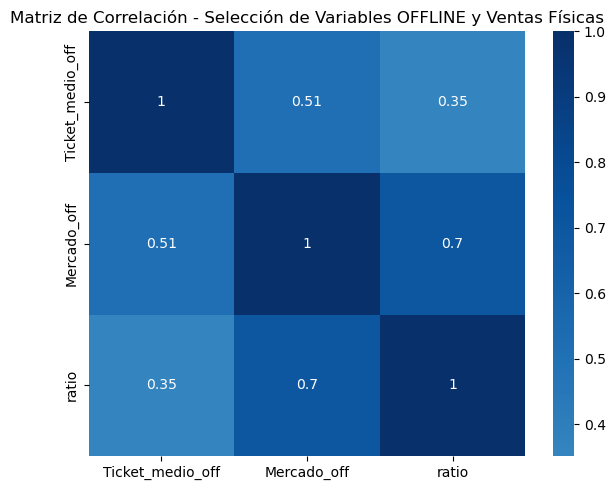

In [39]:

cols_selected = [ 'Ticket_medio_off', 'Mercado_off','ratio']

df_selected_corr = df_merge[cols_selected]
corr_selected = df_selected_corr.corr(numeric_only=True)

# Generar el heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_selected, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Selección de Variables OFFLINE y Ventas Físicas")
plt.tight_layout()
plt.show()

- **Mercado_off** → Correlación alta (0.70)  
Cuando la cuota de mercado  es mayor (supera a la competencia) aumenta el ratio de compra

- **Ticket_medio_off** → Correlación moderada (0.35)  
  A mayor gasto medio por cliente, tiende a subir ligeramente el ratio.

*Nota*:A futuro sería muy intersentante tomar aquellos meses en los cuales la cuota de mercado de la tienda es superior y a qué se debe(en que se está invertiendo el dinero en marketing)

## Time

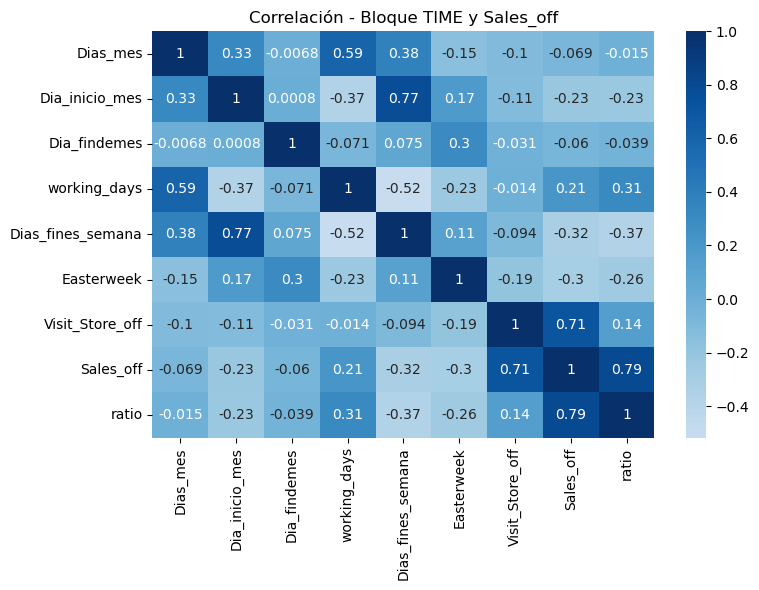

In [40]:
cols_time = ['Dias_mes', 'Dia_inicio_mes', 'Dia_findemes', 'working_days', 'Dias_fines_semana', 'Easterweek', 'Visit_Store_off','Sales_off','ratio']

df_time_corr = df_merge[cols_time]
corr_time = df_time_corr.corr(numeric_only=True)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_time, annot=True, cmap='Blues', center=0)
plt.title("Correlación - Bloque TIME y Sales_off")
plt.tight_layout()
plt.show()

Variables más correlacionadas de la tabla Time: 

-  **working_days** (+0.31) 
- **Dias_fines_semana** (–0.37)  
-  **Easterweek** (–0.26)
- **Dia_inicio_mes** (–0.23)

**Análisis Comportamiento de los usarios**

In [41]:
df_merge.groupby('Easterweek')[['Sales_off','Visit_Store_off']].mean()

,Sales_off,Visit_Store_off
Easterweek,,
0,1762.272727,6147.272727
1,1451.333333,5710.000000


La conversión empeora en Semana Santa pues  hay menos ventas por visitante.

In [42]:
df_merge.groupby('Dias_fines_semana')[['Sales_off','Visit_Store_off']].mean()

,Sales_off,Visit_Store_off
Dias_fines_semana,,
8,1812.526316,6177.368421
9,1715.666667,6026.333333
10,1578.750000,6047.875000


A medida que aumentan los fines de semana en el mes 
- Las ventas disminuyen bastante :1812 → 1579
- Las visitas bajan solo ligeramente :6177 → 6048

In [43]:
df_merge.groupby('Dia_inicio_mes')[['Sales_off','Visit_Store_off']].mean()

,Sales_off,Visit_Store_off
Dia_inicio_mes,,
1,1724.400000,6272.000000
2,1868.000000,6251.666667
3,1932.000000,6156.000000
4,1738.800000,5963.000000
5,1541.666667,5897.333333
6,1609.800000,6091.000000
7,1756.500000,6171.500000


Con respecto al día de incio de mes,las ventas y visitas suben y bajan sin patrón evidente.

## Visit

La tabla visit contiene información sobre el tráfico web 
segmentado por categorí as de producto

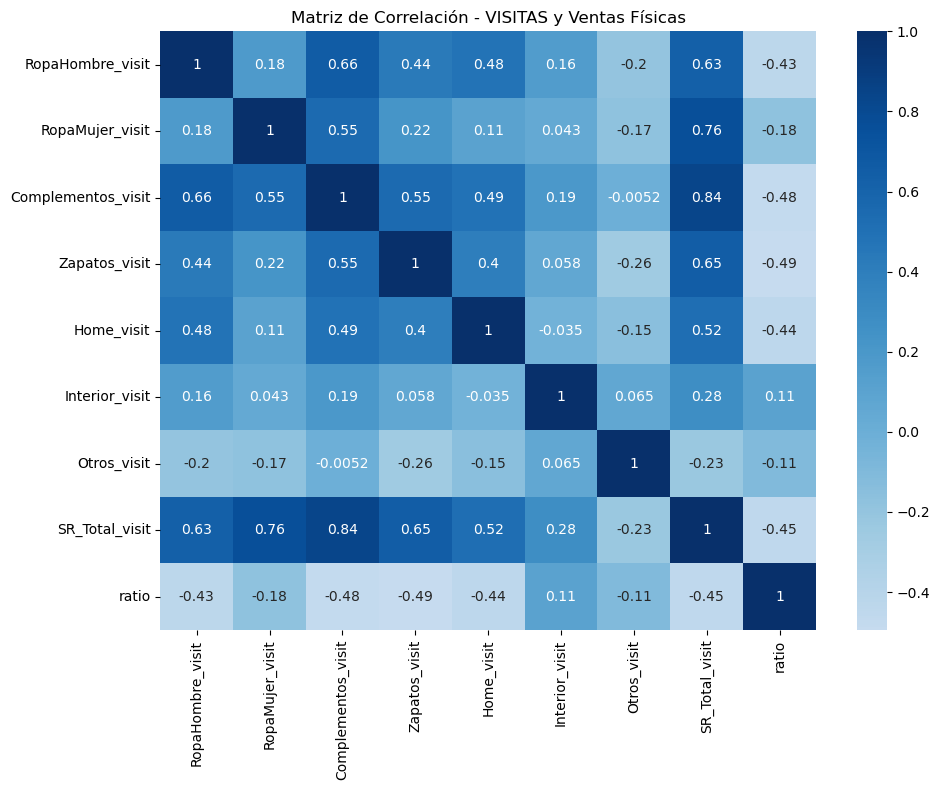

In [44]:
cols_visit = [
    'RopaHombre_visit', 'RopaMujer_visit', 'Complementos_visit', 
    'Zapatos_visit', 'Home_visit', 'Interior_visit', 'Otros_visit', 
    'SR_Total_visit', 'ratio'
]


df_visit_corr = df_merge[cols_visit]


corr_visit = df_visit_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_visit, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - VISITAS y Ventas Físicas")
plt.tight_layout()
plt.show()


Aunque las visitas a la web muestran una **correlación negativa** con  `ratio`.Esto puede deberse a que un mayor interés online genera más visitas a la tienda, pero si la proporción de compras no aumenta al mismo ritmo, el `ratio` tiende a disminuir.


Consideramos incluir estas variables como exógenas en el modelo,
- **Complementos_visit**(-0.48)
- **Zapatos_visit**(−0.49)
- **SR_Total_visit** (−0.45)
- **Home_visit** (−0.44)
- **RopaHombre_visit** (−0.43)

## Web

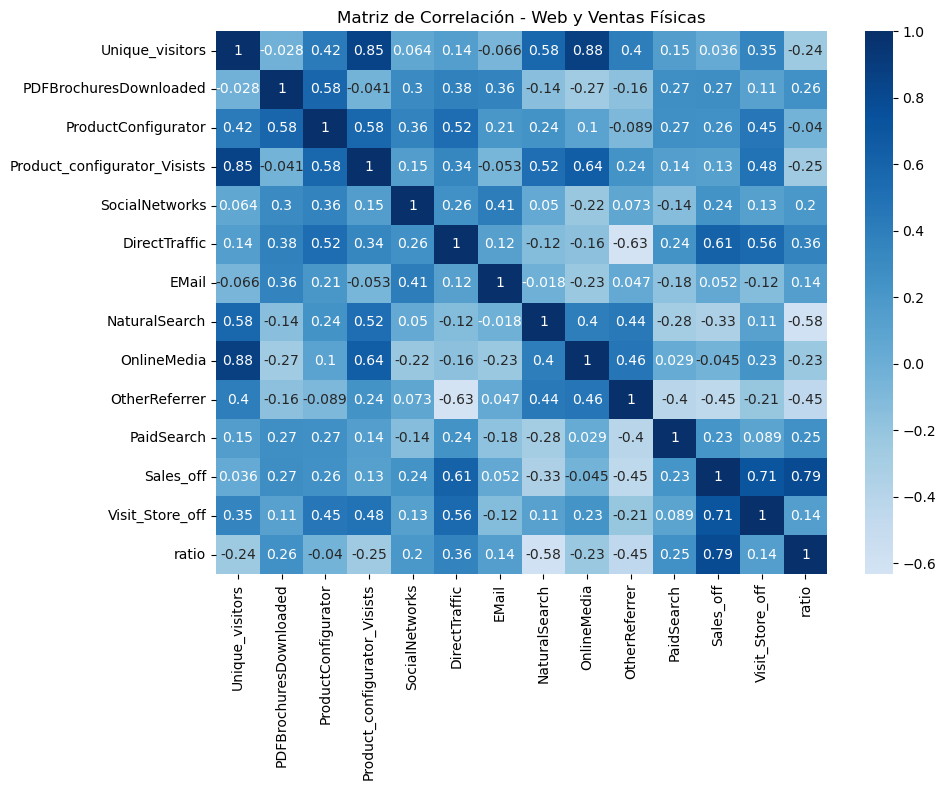

In [45]:
cols_web = [
    'Unique_visitors', 'PDFBrochuresDownloaded', 'ProductConfigurator',
    'Product_configurator_Visists', 'SocialNetworks', 'DirectTraffic',
    'EMail', 'NaturalSearch', 'OnlineMedia', 'OtherReferrer', 'PaidSearch',
    'Sales_off','Visit_Store_off','ratio'
]


df_web_corr = df_merge[cols_web]
corr_web = df_web_corr.corr(numeric_only=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_web, annot=True, cmap='Blues', center=0)
plt.title("Matriz de Correlación - Web y Ventas Físicas")
plt.tight_layout()
plt.show()

**Correlación positiva con `ratio`**

| Variable               | Sales | Visits | Ratio | Interpretación                            |
|------------------------|-------|--------|--------|--------------------------------------------|
| DirectTraffic          | 0.61  | 0.56   | 0.36   | Mejora ventas más que visitas → sube ratio |
| PaidSearch             | 0.23  | 0.09   | 0.25   | Aumenta principalmte las compras                |
| PDFBrochuresDownloaded | 0.27  | 0.11   | 0.26   | Más descargas = más ventas                   |
| SocialNetworks         | 0.24  | 0.13  | 0.24   | Aumenta más compras visitas      |

**Correlación negativa con `ratio`**

| Variable                    | Sales | Visits |  Ratio  | Interpretación                                  |
|-----------------------------|-------|--------|---------|--------------------------------------------------|
| NaturalSearch               | -0.33  | 0.11   |  -0.58  | Dismuye ventas |
| OtherReferrer               | –0.45 | -0.21   |  -0.45  |Dismuye ambos
| Product_configurator_Visits| 0.26  | 0.45  |   –0.25  | Aumenta poco las ventas con respecto visitas       |
| Unique_visitors             | 0.036  | 0.56   |  -0.24  | Muchas visitas web que no compran               |


## Regresión 

In [46]:
df_merge.columns

Index(['ID_Date', 'CINE', 'EXTERIOR', 'INTERNET', 'PRENSA', 'PRODUCCION',
       'RADIO', 'REVISTAS', 'PlataformasVideo', 'VARIOS', 'INV_Total',
       'Inversion_Online', 'Inversion_Offline', 'Inversion_Otros',
       'Unique_visitors', 'PDFBrochuresDownloaded', 'ProductConfigurator',
       'Product_configurator_Visists', 'SocialNetworks', 'DirectTraffic',
       'EMail', 'NaturalSearch', 'OnlineMedia', 'OtherReferrer', 'PaidSearch',
       'Visit_Store_off', 'Mercado_off', 'Sales_off', 'Complementos_off',
       'Ropa_hombre_off', 'Zapatos_off', 'Ropa_Mujer_off', 'Home_off',
       'Interior_off', 'Otros_off', 'Ticket_medio_off', 'Dias_mes',
       'Dia_inicio_mes', 'Dia_findemes', 'working_days', 'Dias_fines_semana',
       'Easterweek', 'RopaHombre_visit', 'RopaMujer_visit',
       'Complementos_visit', 'Zapatos_visit', 'Home_visit', 'Interior_visit',
       'Otros_visit', 'SR_Total_visit', 'ratio', 'delay_1', 'delay_2',
       'sales_1'],
      dtype='object')